/var/folders/gm/0xgpm3y57p301t37196635bw0000gn/T/ipykernel_28789/4013835729.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(all_tiers))


Generating embeddings using labse model...
Generating embeddings using mbert model...
Computing weights for labse with alpha=1.5...


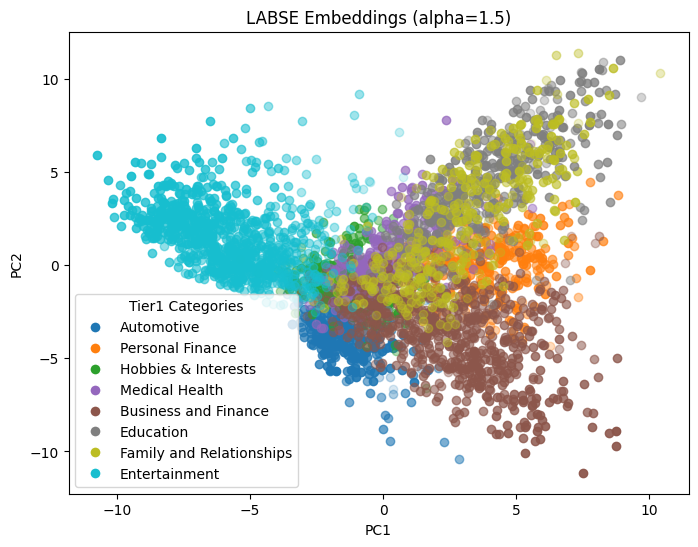

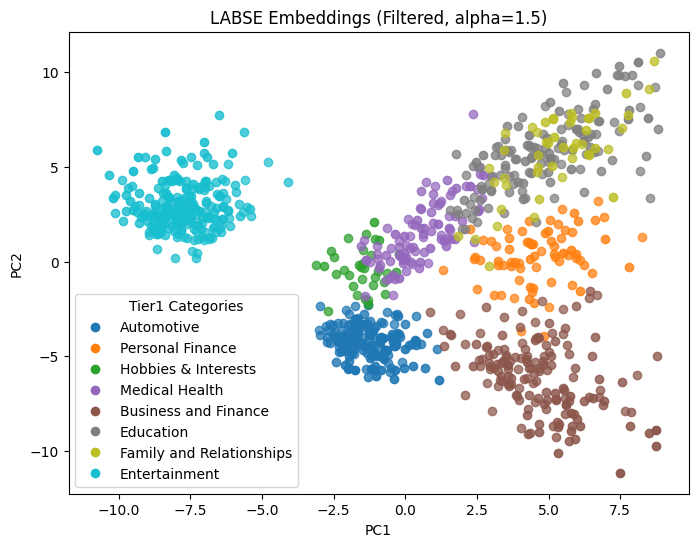

Computing weights for mbert with alpha=1.5...


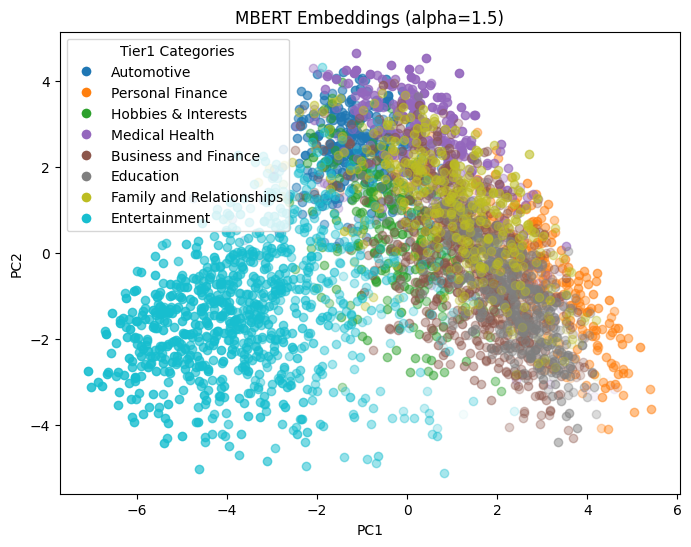

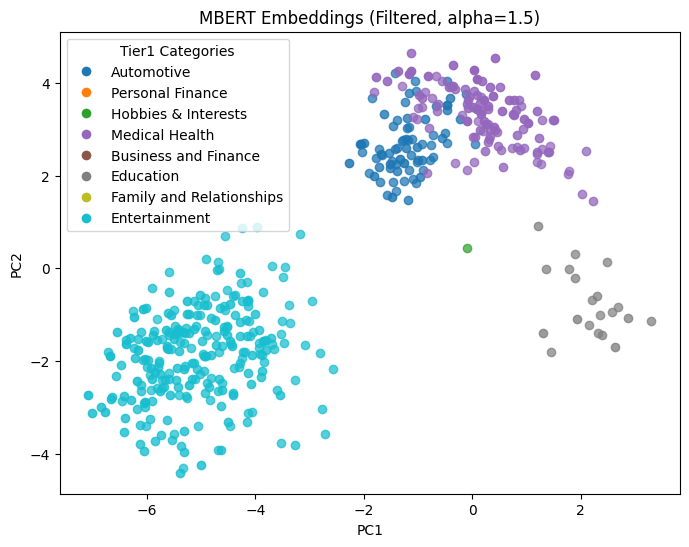

Final CSV saved to output_comparison_alpha1.5.csv


In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
from transformers import AutoTokenizer, AutoModel

# Configuration
INPUT_CSV = "output_with_related_terms_llm_generated_cleaned.csv"
OUTPUT_CSV = "output_comparison_alpha1.5.csv"

MODEL_NAMES = {
    "labse": "sentence-transformers/LaBSE",
    "mbert": "bert-base-multilingual-cased"
}

ALPHA = 1.5  # Run only for alpha value of 1.5

# Step 1: Load and preprocess CSV
df = pd.read_csv(INPUT_CSV)
df['synonyms'] = df['synonyms'].fillna('')
df['synonyms'] = df['synonyms'].str.lower().str.strip()
df['word'] = df['word'].str.lower().str.strip()

df['all_entities'] = df.apply(
    lambda row: [row['word']] + [s.strip() for s in row['synonyms'].split(',') if s.strip() != ''],
    axis=1
)

df_expanded = df.explode('all_entities').rename(columns={'all_entities': 'entity'})
df_expanded = df_expanded.drop_duplicates(subset=['entity', 'tier1', 'tier2', 'tier3'])
entities = df_expanded['entity'].unique().tolist()

entity_to_tier = {}
for _, row in df_expanded.iterrows():
    entity_to_tier[row['entity']] = row['tier1']

all_tiers = df_expanded['tier1'].unique()
colors = plt.cm.get_cmap('tab10', len(all_tiers))
tier_to_color = {t: colors(i) for i, t in enumerate(all_tiers)}

# Utility functions
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def generate_embedding(sentences, tokenizer, model, batch_size=32):
    all_embeddings = []
    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state
            attention_mask = inputs['attention_mask']

            mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
            sum_embeddings = torch.sum(embeddings * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            mean_pooled = sum_embeddings / sum_mask

            all_embeddings.append(mean_pooled)
    return torch.cat(all_embeddings, dim=0).cpu().numpy()

def compute_centroids(entity_embeddings):
    tier1_groups = df_expanded.groupby('tier1')['entity'].apply(list).to_dict()
    cluster_centroids = {}
    for t1, entity_list in tier1_groups.items():
        embs = [entity_embeddings[e] for e in entity_list if e in entity_embeddings]
        if len(embs) > 0:
            centroid = np.mean(embs, axis=0)
            cluster_centroids[t1] = centroid
        else:
            cluster_centroids[t1] = None
    return cluster_centroids

def compute_weights(entities, entity_embeddings, cluster_centroids, alpha):
    raw_weights = []
    for e in entities:
        etier = entity_to_tier[e]
        emb = entity_embeddings[e]
        intra_cluster_sim = 0.0
        if cluster_centroids[etier] is not None:
            intra_cluster_sim = cosine_similarity(emb, cluster_centroids[etier])

        inter_sims = []
        for other_t, other_c in cluster_centroids.items():
            if other_t != etier and other_c is not None:
                inter_sims.append(cosine_similarity(emb, other_c))

        max_inter = max(inter_sims) if inter_sims else 0.0
        diff = intra_cluster_sim - alpha * max_inter
        raw_weights.append(diff)

    raw_weights = np.array(raw_weights)
    diff_min, diff_max = raw_weights.min(), raw_weights.max()
    if diff_max == diff_min:
        normalized = np.ones_like(raw_weights)
    else:
        normalized = (raw_weights - diff_min) / (diff_max - diff_min)
    return {e: w for e, w in zip(entities, normalized)}

def plot_embeddings(entities, entity_embeddings, weights_dict=None, filter_weights=False, title="Embeddings", filename="plot.png"):
    embs = np.array([entity_embeddings[e] for e in entities])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embs)

    plt.figure(figsize=(8, 6))
    for (x, y, e) in zip(reduced[:, 0], reduced[:, 1], entities):
        alpha = weights_dict[e] if weights_dict else 1.0
        if filter_weights and alpha < 0.7:
            continue
        plt.scatter(x, y, alpha=alpha, c=[tier_to_color[entity_to_tier[e]]])
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=t,
                markerfacecolor=tier_to_color[t], markersize=8) for t in all_tiers]
    plt.legend(handles=handles, title="Tier1 Categories")

    plt.savefig(filename, dpi=300)
    plt.show()

# Step 2: Generate embeddings for both models
model_data = {}
for model_key, model_name in MODEL_NAMES.items():
    print(f"Generating embeddings using {model_key} model...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    embeddings = generate_embedding(entities, tokenizer, model)
    entity_embeddings = {e: emb for e, emb in zip(entities, embeddings)}
    model_data[model_key] = {
        "embeddings": entity_embeddings,
        "centroids": compute_centroids(entity_embeddings)
    }

# Step 3: Compute weights for alpha = 1.5 and plot
for model_key in MODEL_NAMES.keys():
    print(f"Computing weights for {model_key} with alpha={ALPHA}...")
    weights = compute_weights(entities, model_data[model_key]["embeddings"], model_data[model_key]["centroids"], ALPHA)

    # Plot embeddings with weight as opacity
    plot_embeddings(entities, model_data[model_key]["embeddings"], weights,
                    title=f"{model_key.upper()} Embeddings (alpha={ALPHA})",
                    filename=f"{model_key}_alpha{ALPHA}.png")

    # Plot embeddings with weight as opacity, filtering weights < 0.7
    plot_embeddings(entities, model_data[model_key]["embeddings"], weights, filter_weights=True,
                    title=f"{model_key.upper()} Embeddings (Filtered, alpha={ALPHA})",
                    filename=f"{model_key}_alpha{ALPHA}_filtered.png")

# Step 4: Produce final CSV
output_rows = []
for e in entities:
    row = {
        "entity": e,
        "labse_embedding": json.dumps(model_data["labse"]["embeddings"][e].tolist()),
        "mbert_embedding": json.dumps(model_data["mbert"]["embeddings"][e].tolist()),
        f"labse_weight_alpha{ALPHA}": weights[e],
        f"mbert_weight_alpha{ALPHA}": weights[e]
    }
    output_rows.append(row)

out_df = pd.DataFrame(output_rows)
out_df.to_csv(OUTPUT_CSV, index=False)
print(f"Final CSV saved to {OUTPUT_CSV}")
